In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/public_data_test/track_c/test/ind.csv
/kaggle/input/public_data_test/track_c/test/tat.csv
/kaggle/input/public_data_test/track_c/test/swe.csv
/kaggle/input/public_data_test/track_c/test/afr.csv
/kaggle/input/public_data_test/track_c/test/xho.csv
/kaggle/input/public_data_test/track_c/test/amh.csv
/kaggle/input/public_data_test/track_c/test/ptbr.csv
/kaggle/input/public_data_test/track_c/test/mar.csv
/kaggle/input/public_data_test/track_c/test/eng.csv
/kaggle/input/public_data_test/track_c/test/yor.csv
/kaggle/input/public_data_test/track_c/test/hau.csv
/kaggle/input/public_data_test/track_c/test/som.csv
/kaggle/input/public_data_test/track_c/test/ron.csv
/kaggle/input/public_data_test/track_c/test/zul.csv
/kaggle/input/public_data_test/track_c/test/sun.csv
/kaggle/input/public_data_test/track_c/test/arq.csv
/kaggle/input/public_data_test/track_c/test/hin.csv
/kaggle/input/public_data_test/track_c/test/ibo.csv
/kaggle/input/public_data_test/track_c/test/chn.csv
/kaggle/inp

# Install Libraries and Modules

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.1
Uninstalling wandb-0.19.1:
  Successfully uninstalled wandb-0.19.1


In [4]:
!pip install wandb==0.17.5 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.3 MB/s eta 0:00:0000:0100:01


In [5]:
import wandb

In [6]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [7]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [8]:
!pip install datasets transformers evaluate sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer, XLMRobertaTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [56]:
train_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/train/swe.csv")

dev_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/swe.csv")

test_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/test/swe.csv")

# SWEDISH

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment
- https://huggingface.co/marma/bert-base-swedish-cased-sentiment
- https://huggingface.co/google-bert/bert-base-multilingual-cased
- https://huggingface.co/FacebookAI/xlm-roberta-base
- https://huggingface.co/KBLab/robust-swedish-sentiment-multiclass

In [12]:
train_swe.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,swe_train_track_a_00001,Riktigt usel service - fick serverat en hambur...,0,1,0,0,0,0
1,swe_train_track_a_00002,Vi fyttade från ett hus till mina föräldrars h...,1,1,0,0,0,0
2,swe_train_track_a_00003,Till slut vände hon sig mot fönstret omkring t...,0,0,0,0,0,0
3,swe_train_track_a_00004,Mycket pålitlig person. Ger trygghet. Förbered...,0,0,0,1,0,0
4,swe_train_track_a_00005,Funderar du på att hjälpa till?,0,0,0,0,0,0


In [13]:
train_swe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187 entries, 0 to 1186
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1187 non-null   object
 1   text      1187 non-null   object
 2   anger     1187 non-null   int64 
 3   disgust   1187 non-null   int64 
 4   fear      1187 non-null   int64 
 5   joy       1187 non-null   int64 
 6   sadness   1187 non-null   int64 
 7   surprise  1187 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.3+ KB


In [14]:
dev_swe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        200 non-null    object
 1   text      200 non-null    object
 2   anger     200 non-null    int64 
 3   disgust   200 non-null    int64 
 4   fear      200 non-null    int64 
 5   joy       200 non-null    int64 
 6   sadness   200 non-null    int64 
 7   surprise  200 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 12.6+ KB


<Axes: >

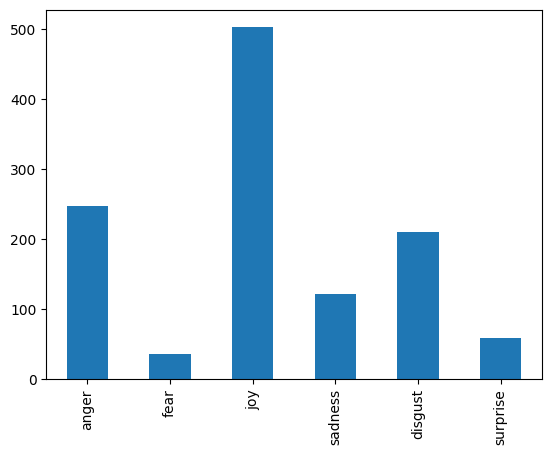

In [15]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']
train_swe[attributes].sum().plot.bar()

<Axes: >

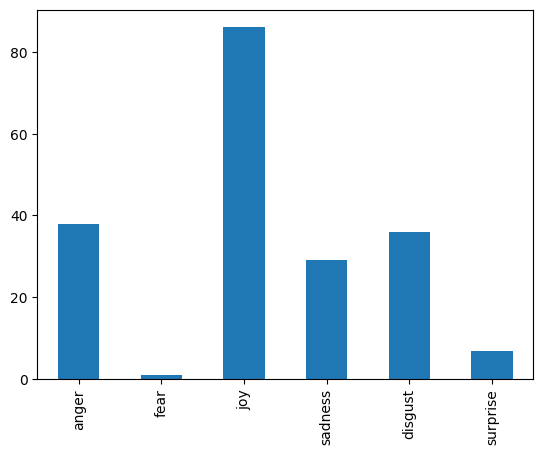

In [16]:
dev_swe[attributes].sum().plot.bar()

In [17]:
test_swe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1188 non-null   object 
 1   text      1188 non-null   object 
 2   anger     0 non-null      float64
 3   disgust   0 non-null      float64
 4   fear      0 non-null      float64
 5   joy       0 non-null      float64
 6   sadness   0 non-null      float64
 7   surprise  0 non-null      float64
dtypes: float64(6), object(2)
memory usage: 74.4+ KB


In [18]:
test_swe.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,swe_test_track_a_00001,"- Kom, ni kan raka er sen.",NaN,NaN,NaN,NaN,NaN,NaN
1,swe_test_track_a_00002,Gick väldigt smidigt att köpa bostad genom Vik...,NaN,NaN,NaN,NaN,NaN,NaN
2,swe_test_track_a_00003,Trevligt bemötta och hela afgäre gick smidigt.,NaN,NaN,NaN,NaN,NaN,NaN
3,swe_test_track_a_00004,"Hej, jag tog med Livet är underbart om ni vill...",NaN,NaN,NaN,NaN,NaN,NaN
4,swe_test_track_a_00005,Nonchalant mäklare som har svårt för att lyssn...,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

# BERT Based Swedish Cased Sentiment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('marma/bert-base-swedish-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('marma/bert-base-swedish-cased-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

vocab.txt:   0%|          | 0.00/399k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at marma/bert-base-swedish-cased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

In [ ]:
def encode_data(df, tokenizer):
    encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=512)
    labels = df[emotion_labels].fillna(0).values
    return encodings, labels

In [62]:
train_encodings, train_labels = encode_data(train_swe, tokenizer)
dev_encodings, dev_labels = encode_data(dev_swe, tokenizer)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [64]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [21]:
train_dataset

In [ ]:
train_dataset.encodings

In [ ]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

train_lengths = calculate_token_lengths(train_swe['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_swe['text'], tokenizer)
test_lengths = calculate_token_lengths(test_swe['text'], tokenizer)

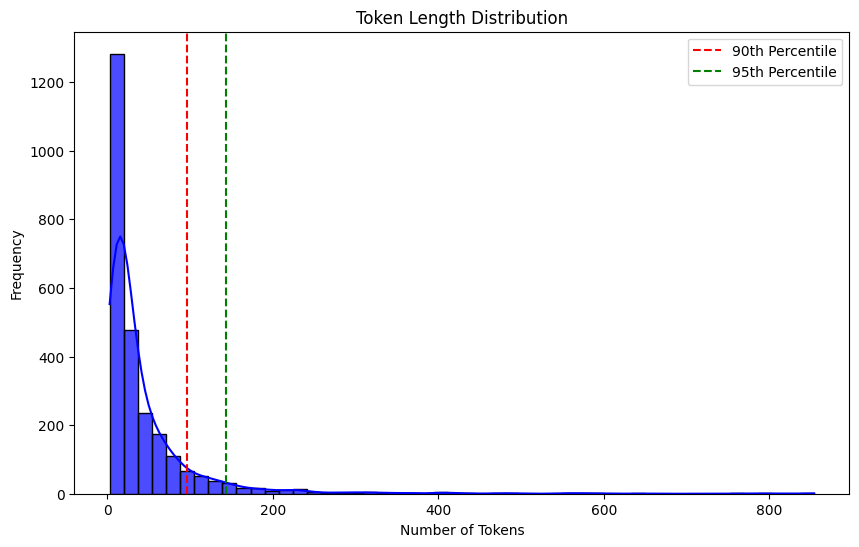

In [ ]:
all_lengths = train_lengths + dev_lengths + test_lengths

plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
def compute_metrics(pred, threshold=0.5):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > threshold).numpy()
    labels = labels.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/swe/bert_based_swedish_cased_sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [44]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [42]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.164300,0.213308,0.615000,0.716675,0.667311,0.781726
1000,0.061600,0.230863,0.670000,0.749459,0.745850,0.756345
1500,0.030000,0.245389,0.675000,0.735506,0.755250,0.720812
2000,0.015600,0.260726,0.675000,0.762063,0.758677,0.766497
2500,0.009600,0.270255,0.680000,0.750354,0.751994,0.751269
3000,0.007100,0.283736,0.690000,0.754105,0.763558,0.746193
3500,0.005300,0.292964,0.690000,0.765342,0.771539,0.761421
4000,0.004300,0.305824,0.675000,0.745418,0.752065,0.741117
4500,0.003700,0.319262,0.670000,0.737997,0.746625,0.730964
5000,0.003100,0.320184,0.685000,0.742896,0.751506,0.736041


In [ ]:
def find_best_threshold(pred, thresholds):
    best_threshold = 0.5
    best_f1 = 0
    
    for t in thresholds:
        metrics = compute_metrics(pred, threshold=t)
        print(f"metrics: {metrics}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t

    return best_threshold, best_f1

In [ ]:
def evaluate_on_validation_set(trainer, threshold_range=np.linspace(0.1, 0.9, 9)):
    predictions, labels, _ = trainer.predict(dev_dataset) 
    pred = (predictions, labels)

    best_threshold, best_f1 = find_best_threshold(pred, thresholds=threshold_range)
    print("----------------------------------------------")
    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")
    print("***********************************************")
    final_metrics = compute_metrics(pred, threshold=best_threshold)
    print(f"Metrics with Best Threshold: {final_metrics}")

    return best_threshold, final_metrics

In [45]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.48, 'f1': 0.6840620498849822, 'precision': 0.573285376726829, 'recall': 0.8781725888324873}
metrics: {'accuracy': 0.575, 'f1': 0.7270457197468164, 'precision': 0.6497429295426251, 'recall': 0.8375634517766497}
metrics: {'accuracy': 0.615, 'f1': 0.7166745849702938, 'precision': 0.667311296053391, 'recall': 0.7817258883248731}
metrics: {'accuracy': 0.655, 'f1': 0.727475836652619, 'precision': 0.7185204278381608, 'recall': 0.751269035532995}
metrics: {'accuracy': 0.66, 'f1': 0.7084301441010309, 'precision': 0.728099301548602, 'recall': 0.7106598984771574}
metrics: {'accuracy': 0.66, 'f1': 0.6934406304873356, 'precision': 0.7703715557408041, 'recall': 0.6649746192893401}
metrics: {'accuracy': 0.66, 'f1': 0.6670848824056845, 'precision': 0.8053715517363955, 'recall': 0.6142131979695431}
metrics: {'accuracy': 0.645, 'f1': 0.5850643667173258, 'precision': 0.8578460456633046, 'recall': 0.5228426395939086}
metrics: {'accuracy': 0.625, 'f1': 0.44689827938558907, 'precisio

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.4).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

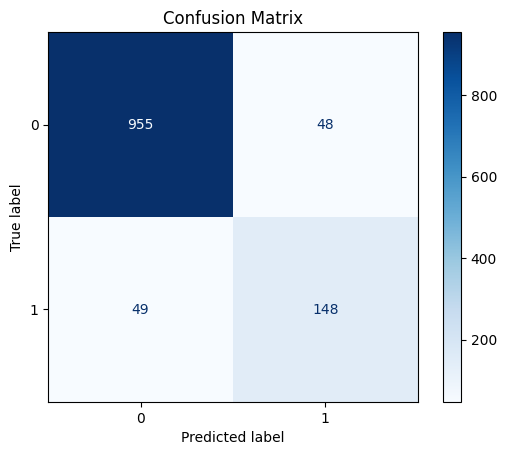

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

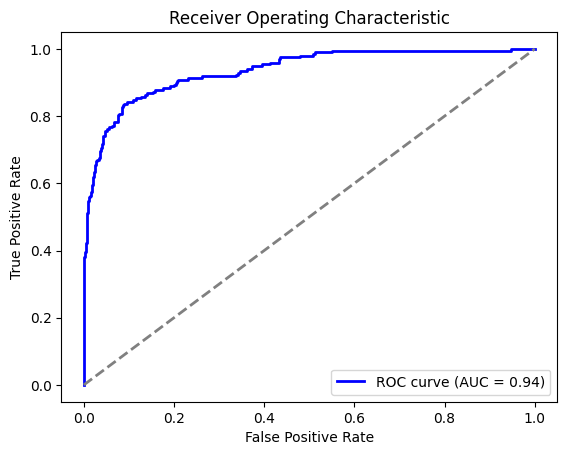

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.6550
anger: Precision=0.6739, Recall=0.8158, F1=0.7381
disgust: Precision=0.6154, Recall=0.6667, F1=0.6400
fear: Precision=0.0000, Recall=0.0000, F1=0.0000
joy: Precision=0.8723, Recall=0.9535, F1=0.9111
sadness: Precision=0.6471, Recall=0.3793, F1=0.4783
surprise: Precision=0.0000, Recall=0.0000, F1=0.0000


In [ ]:
test_encodings = tokenizer(list(test_swe['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_swe), 6)))
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.4).numpy()

In [ ]:
test_swe[emotion_labels] = test_predictions
test_swe.to_csv('test_predictions_swe_bert_based_swedish_cased_sentiment_v1.csv', index=False)

In [52]:
test_swe.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,swe_test_track_a_00001,"- Kom, ni kan raka er sen.",False,False,False,False,False,False
1,swe_test_track_a_00002,Gick väldigt smidigt att köpa bostad genom Vik...,False,False,False,True,False,False
2,swe_test_track_a_00003,Trevligt bemötta och hela afgäre gick smidigt.,False,False,False,True,False,False
3,swe_test_track_a_00004,"Hej, jag tog med Livet är underbart om ni vill...",False,False,False,True,False,False
4,swe_test_track_a_00005,Nonchalant mäklare som har svårt för att lyssn...,False,True,False,False,False,False


# BERT Base Multilingual Cased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-multilingual-cased',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/swe/bert-base-multi-cased-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [66]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.190900,0.245745,0.625000,0.670567,0.714185,0.639594
1000,0.091100,0.261610,0.610000,0.688629,0.681578,0.705584
1500,0.041000,0.310605,0.635000,0.665555,0.698073,0.649746
2000,0.017300,0.333055,0.615000,0.681275,0.699269,0.675127
2500,0.009700,0.344804,0.630000,0.694401,0.707765,0.690355
3000,0.006800,0.392068,0.620000,0.678118,0.714556,0.659898
3500,0.005000,0.389818,0.625000,0.674855,0.699366,0.664975
4000,0.003800,0.411090,0.620000,0.675996,0.733949,0.654822
4500,0.003300,0.440901,0.620000,0.666198,0.710939,0.644670
5000,0.002800,0.432518,0.615000,0.672921,0.701831,0.659898


In [67]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.455, 'f1': 0.6812570449836791, 'precision': 0.5927080026222441, 'recall': 0.8375634517766497}
metrics: {'accuracy': 0.62, 'f1': 0.7289128487392079, 'precision': 0.6964901406216252, 'recall': 0.766497461928934}
metrics: {'accuracy': 0.625, 'f1': 0.6705665564535367, 'precision': 0.7141852601611821, 'recall': 0.6395939086294417}
metrics: {'accuracy': 0.63, 'f1': 0.5762628232429018, 'precision': 0.6843250851433048, 'recall': 0.5279187817258884}
metrics: {'accuracy': 0.62, 'f1': 0.5610277578727403, 'precision': 0.7123388404961397, 'recall': 0.5025380710659898}
metrics: {'accuracy': 0.625, 'f1': 0.5281377266318559, 'precision': 0.6962531092777473, 'recall': 0.4720812182741117}
metrics: {'accuracy': 0.615, 'f1': 0.4775817473103105, 'precision': 0.7189321300996427, 'recall': 0.43147208121827413}
metrics: {'accuracy': 0.6, 'f1': 0.410881683548928, 'precision': 0.6007213465134918, 'recall': 0.3756345177664975}
metrics: {'accuracy': 0.585, 'f1': 0.3749837303136796, 'precis

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.2).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

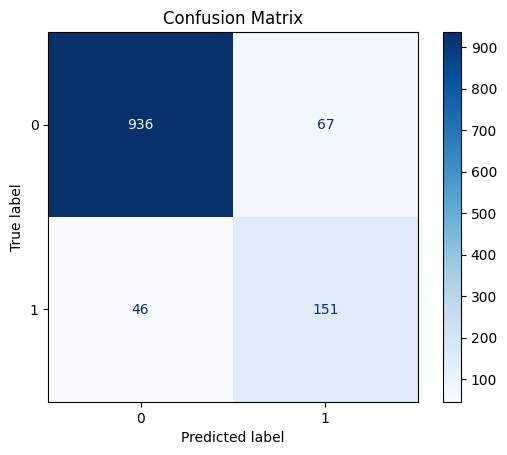

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

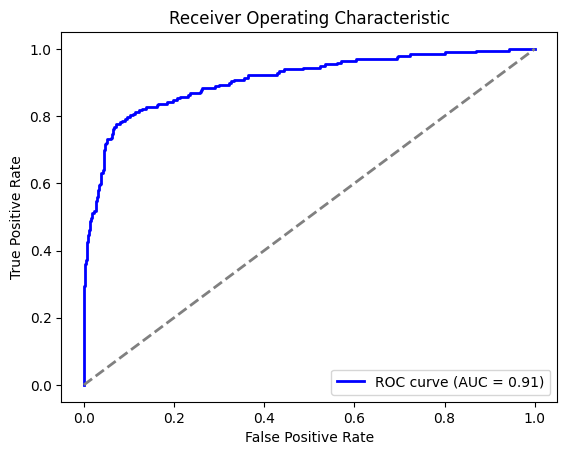

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.6200
anger: Precision=0.7317, Recall=0.7895, F1=0.7595
disgust: Precision=0.5909, Recall=0.7222, F1=0.6500
fear: Precision=0.0000, Recall=0.0000, F1=0.0000
joy: Precision=0.8571, Recall=0.9070, F1=0.8814
sadness: Precision=0.4167, Recall=0.5172, F1=0.4615
surprise: Precision=0.3333, Recall=0.2857, F1=0.3077


In [ ]:
test_encodings = tokenizer(list(test_swe['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_swe), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.2).numpy()

In [ ]:
test_swe[emotion_labels] = test_predictions
test_swe.to_csv('test_predictions_swe_mbert_base_cased_v1.csv', index=False)

# Twitter XLM RoBERTa Base Sentiment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/swe/twitter-xlm-roberta-base-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model = 'f1',
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [27]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.191800,0.213637,0.670000,0.671936,0.776857,0.644670
1000,0.122300,0.228418,0.670000,0.718133,0.757065,0.710660
1500,0.066600,0.252018,0.650000,0.691743,0.749962,0.654822
2000,0.032400,0.270998,0.665000,0.702710,0.762036,0.659898
2500,0.016600,0.282649,0.660000,0.702273,0.729671,0.680203


In [28]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.58, 'f1': 0.7377652501747065, 'precision': 0.671304256838146, 'recall': 0.8375634517766497}
metrics: {'accuracy': 0.655, 'f1': 0.7278418971740445, 'precision': 0.7138110150446133, 'recall': 0.766497461928934}
metrics: {'accuracy': 0.66, 'f1': 0.718026494985762, 'precision': 0.7171838446259103, 'recall': 0.7411167512690355}
metrics: {'accuracy': 0.66, 'f1': 0.7159043716563134, 'precision': 0.7292400774634277, 'recall': 0.7258883248730964}
metrics: {'accuracy': 0.67, 'f1': 0.7181332219002535, 'precision': 0.7570647179037744, 'recall': 0.7106598984771574}
metrics: {'accuracy': 0.685, 'f1': 0.7050623940655012, 'precision': 0.7896660421294641, 'recall': 0.6852791878172588}
metrics: {'accuracy': 0.67, 'f1': 0.6697408242030048, 'precision': 0.8171515061477068, 'recall': 0.6345177664974619}
metrics: {'accuracy': 0.655, 'f1': 0.6550071121771629, 'precision': 0.8268708772726875, 'recall': 0.6040609137055838}
metrics: {'accuracy': 0.61, 'f1': 0.5820215514939023, 'precision

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.1).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

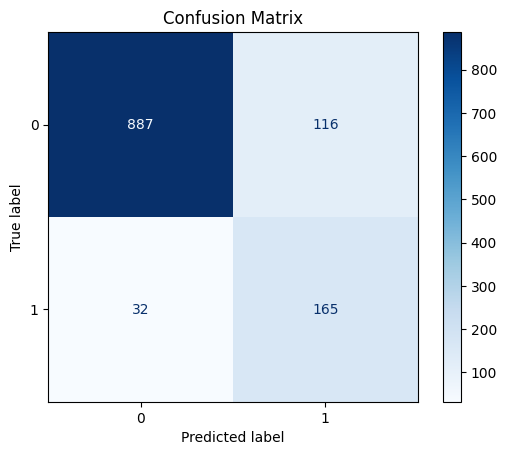

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

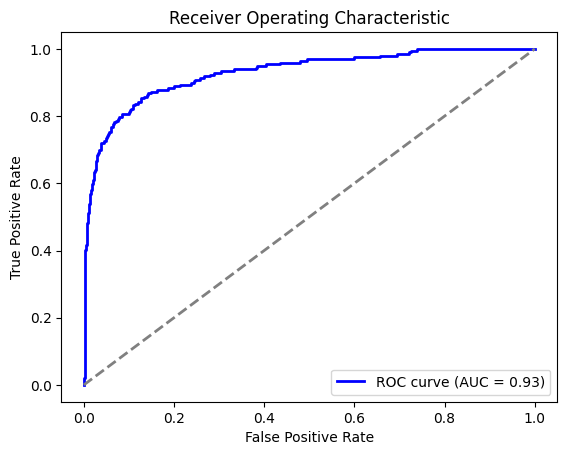

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.5800
anger: Precision=0.5738, Recall=0.9211, F1=0.7071
disgust: Precision=0.5094, Recall=0.7500, F1=0.6067
fear: Precision=0.0000, Recall=0.0000, F1=0.0000
joy: Precision=0.8696, Recall=0.9302, F1=0.8989
sadness: Precision=0.5714, Recall=0.6897, F1=0.6250
surprise: Precision=0.1071, Recall=0.4286, F1=0.1714


In [35]:
test_encodings = tokenizer(list(test_swe['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_swe), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.1).numpy()

test_swe[emotion_labels] = test_predictions
test_swe.to_csv('test_predictions_swe_twitter_xlm_roberta_base_sentiment_v1.csv', index=False)

# XLM RoBERTa Base

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-base',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/swe/xlm-roberta-base-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model = 'f1',
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [49]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.207200,0.203541,0.685000,0.690570,0.769571,0.685279
1000,0.140700,0.213158,0.660000,0.714179,0.706424,0.730964
1500,0.088300,0.251137,0.635000,0.730355,0.732236,0.736041
2000,0.046100,0.269860,0.655000,0.752695,0.765364,0.756345
2500,0.025900,0.281863,0.645000,0.730264,0.728229,0.736041
3000,0.015000,0.312101,0.645000,0.746780,0.735891,0.761421
3500,0.008600,0.324642,0.625000,0.732996,0.715599,0.756345


In [50]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.605, 'f1': 0.7531779083144279, 'precision': 0.6839985969413954, 'recall': 0.8527918781725888}
metrics: {'accuracy': 0.625, 'f1': 0.7643525409534486, 'precision': 0.7237871488530336, 'recall': 0.8223350253807107}
metrics: {'accuracy': 0.645, 'f1': 0.7524886588139856, 'precision': 0.7262420819846724, 'recall': 0.7918781725888325}
metrics: {'accuracy': 0.645, 'f1': 0.7593499432933719, 'precision': 0.7505564232721593, 'recall': 0.7817258883248731}
metrics: {'accuracy': 0.655, 'f1': 0.7526947685092945, 'precision': 0.765363707707134, 'recall': 0.7563451776649747}
metrics: {'accuracy': 0.65, 'f1': 0.7355611957134799, 'precision': 0.767706067198453, 'recall': 0.7208121827411168}
metrics: {'accuracy': 0.65, 'f1': 0.7168082672083361, 'precision': 0.7658601779131894, 'recall': 0.6802030456852792}
metrics: {'accuracy': 0.64, 'f1': 0.6913299250539762, 'precision': 0.7597527071571468, 'recall': 0.6395939086294417}
metrics: {'accuracy': 0.615, 'f1': 0.652830433480362, 'precis

In [ ]:
dev_results = trainer.predict(dev_dataset)

predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.2).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

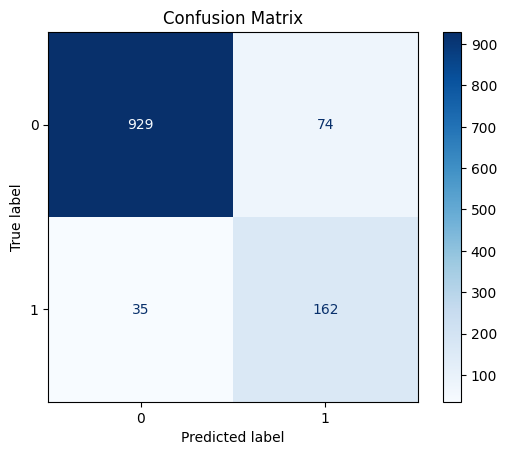

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

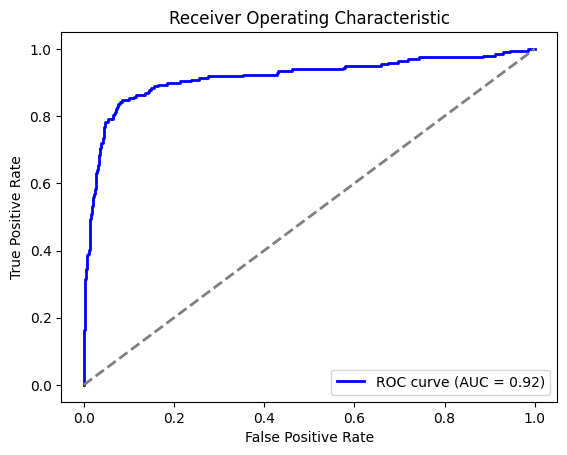

In [ ]:
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(emotion_labels):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.6250
anger: Precision=0.6604, Recall=0.9211, F1=0.7692
disgust: Precision=0.7097, Recall=0.6111, F1=0.6567
fear: Precision=0.0000, Recall=0.0000, F1=0.0000
joy: Precision=0.8817, Recall=0.9535, F1=0.9162
sadness: Precision=0.5000, Recall=0.6897, F1=0.5797
surprise: Precision=0.2308, Recall=0.4286, F1=0.3000


In [55]:
test_encodings = tokenizer(list(test_swe['text']), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_swe), 6)))  # Dummy labels for test
test_results = trainer.predict(test_dataset)
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.2).numpy()

test_swe[emotion_labels] = test_predictions
test_swe.to_csv('test_predictions_swe_xlm_roberta_base_v1.csv', index=False)

# Robust Swedish Sentiment Multiclass
Out of Memory...

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('KBLab/robust-swedish-sentiment-multiclass')
model = AutoModelForSequenceClassification.from_pretrained('KBLab/robust-swedish-sentiment-multiclass',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

tokenizer_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/906 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of MegatronBertForSequenceClassification were not initialized from the model checkpoint at KBLab/robust-swedish-sentiment-multiclass and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([6, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
training_args = TrainingArguments(
    output_dir='./results/swe/robust-swedish-sentiment-mc-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model = 'f1',
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [69]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [70]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 1500, in forward
    outputs = self.bert(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 972, in forward
    encoder_outputs = self.encoder(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 560, in forward
    layer_outputs = layer_module(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 446, in forward
    self_attention_outputs = self.attention(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 374, in forward
    self_outputs = self.self(
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/megatron_bert/modeling_megatron_bert.py", line 310, in forward
    context_layer = torch.matmul(attention_probs, value_layer)
torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 2236 has 14.73 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 150.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
